In [3]:
%%time
%load_ext autoreload

from analysis_utils import *
from joblib import Parallel, delayed
import multiprocessing  
import numpy as np
import pandas as pd

#Growth rate = 3.0
#Computes the translation latencies from our model with simulations containing
#1 to 14 cognate ternary complexes in the voxel (14 to 42 not included because
#the probability of voxels with that number of cognates is ~0)
path = "./data/"
ensmbl_latency_dict = dict()
rxndiff=dict()
scalingFactor = 200
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}

data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data,100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))
    
#Experimentally obtained codon usage frequencies and tRNA abundances at growth rate = 2.5 dbl/hr
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 7.93 s, sys: 214 ms, total: 8.15 s
Wall time: 8.37 s


In [4]:
def perturb(ptRNA,tRNA,tRNA_sorted, pCodon,ensmbl_latency_dict,pos,delta,skip=False):
    #Delta is not taken into the account in this function (hard coded as 0.1)
    
    ptRNA_red20 = np.array([0.07175573, 0.        , 0.09770992, 0.        , 0.        ,
       0.        , 0.02137405, 0.04427481, 0.02137405, 0.        ,
       0.03053435, 0.08549618, 0.10534351, 0.        , 0.01221374,
       0.07175573, 0.        , 0.        , 0.12824427, 0.        ,
       0.        , 0.03053435, 0.01374046, 0.01526718, 0.0259542 ,
       0.        , 0.        , 0.        , 0.05496183, 0.        ,
       0.        , 0.        , 0.04732824, 0.        , 0.        ,
       0.        , 0.01526718, 0.02748092, 0.        , 0.07938931])
    ptRNA_maxval = max(np.array(ptRNA_red20)[np.nonzero(np.array(ptRNA_red20))])
    ptRNA_minval = min(np.array(ptRNA_red20)[np.nonzero(np.array(ptRNA_red20))])
    ptRNA_dict = dict(zip(tRNA, ptRNA))
    tRNA_1 = tRNA_sorted[pos]
    tRNA_0 = tRNA_sorted[pos-1]
    
    if pos==0:
        raise ValueError("pos cannot be zero")
        print("error")
        
    if  0.524*(ptRNA_dict[tRNA_0]+ptRNA_dict[tRNA_1]) > ptRNA_maxval:
        ptRNA_dict[tRNA_1] = ptRNA_dict[tRNA_1] - (ptRNA_maxval-ptRNA_dict[tRNA_0])
        ptRNA_dict[tRNA_0] = ptRNA_maxval
        
    elif 0.426*(ptRNA_dict[tRNA_0]+ptRNA_dict[tRNA_1]) < ptRNA_minval:
        ptRNA_dict[tRNA_0] = ptRNA_dict[tRNA_0] + (ptRNA_dict[tRNA_1]-ptRNA_minval)
        ptRNA_dict[tRNA_1] = ptRNA_minval
        
    else: 
        tot = (ptRNA_dict[tRNA_0]+ptRNA_dict[tRNA_1])
        ptRNA_dict[tRNA_1] = 0.476*tot
        ptRNA_dict[tRNA_0] = 0.524*tot
    
    arr = []
    if sum(ptRNA_dict.values())>1.0000001:
        print("Total over 1.0: ", sum(ptRNA_dict.values()))
    
    N=100
    if(skip):
        N=1
    for i in range(N):
        arr.append(computeElongationLatency(np.array(list(ptRNA_dict.values())), pCodon, ensmbl_latency_dict)[0][0])
    
    return np.average(arr), np.array(list(ptRNA_dict.values())),np.std(arr)/np.sqrt(N)
def monotonicity(ptRNA):
    if (len(ptRNA)==20):
        return (sum(np.diff(ptRNA) <= 0)/20)*100
    else:
        raise ValueError("Length of ptRNA is not 20")
        print("Length of ptRNA is not 20")

# Single gene perturubation analysis (RED20 GFP)


In [5]:
tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
"Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
"Met_m", "Phe", "Pro1", "Pro2", "Pro3", "Sel_Cys", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
"Thr2", "Thr3", "Thr4", "Trp", "Tyr1pTyr2", "Val1", "Val2ApB"]
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

#Loading GA fast and slow RED20-GFP distributions
import pickle
with open(r"./tRNA_distributions-GFP.pickle", "rb") as input_file:
    e = pickle.load(input_file)
e.keys()

#pCodon and ptRNA setup
gene_map, pCodon_GFP = singlegene_to_genemap('./data/tables/sfGFP_RED20.csv')
ptRNA_red20 = pd.read_excel('./data/tables/tRNAValues_RED20.xlsx',header=None)
ptRNA_red20 = ptRNA_red20[6]/sum(ptRNA_red20[6])
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(ptRNA_red20,pCodon_GFP,extra2=True)

#Sort tRNA by codon usage in transcriptome and plot baseline tRNA frequency
tRNA_sum_dict = tRNA_dict.copy()
tRNA_weightedbycodon = list()
for keys in tRNA_dict.keys():
    tRNA_sum_dict[keys] = (sum([pcodon_dict[tRNA_key] for tRNA_key in tRNA_dict[keys]]))
tRNA_weightedbycodon = list(tRNA_sum_dict.values())/sum(tRNA_sum_dict.values())
tRNA_sorted_indices = np.flip(tRNA_weightedbycodon.argsort())
tRNA_sorted = np.array(tRNA_tags)[tRNA_sorted_indices]
ptRNA_sorted = gr25_ptRNA[tRNA_sorted_indices]

ptRNA_sorted=np.delete(ptRNA_sorted,5)
ptRNA_sorted=np.delete(ptRNA_sorted,12)
tRNA_sorted=np.delete(tRNA_sorted,5)
tRNA_sorted=np.delete(tRNA_sorted,12)

#Resort ptRNA_min and plot
GA_fast_values =np.array(list(e['GFP_gafast'][1].values()))
ptRNA_min_dict = dict(zip(tRNA_tags,GA_fast_values))
ptRNA_min_sorted=[ptRNA_min_dict[tRNA] for tRNA in tRNA_sorted]

fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(20),np.array(ptRNA_min_sorted)[0:20],color='darkseagreen',width=0.8,alpha=0.7)
ax.plot(np.arange(20),[1/20]*20,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(np.arange(20), np.array(tRNA_sorted)[0:20],rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,20)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_ylim(0,0.13)

plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: './data/tables/tRNAValues_RED20.xlsx'

[0.08207273693853659, 0.09714887016803621, 0.08824973702287257, 0.07091250645697382, 0.08520426515877168, 0.0754751853552089, 0.09676048713507972, 0.059981364885348526, 0.06622090069588156, 0.05074935073554299, 0.020539831304472365, 0.04107876164977899, 0.016644118014926993, 0.013176498402154959, 0.03618178216935147, 0.048204638114246794, 0.012545073592836742, 0.012545073592836742, 0.014095078149276317, 0.012213740457866095, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


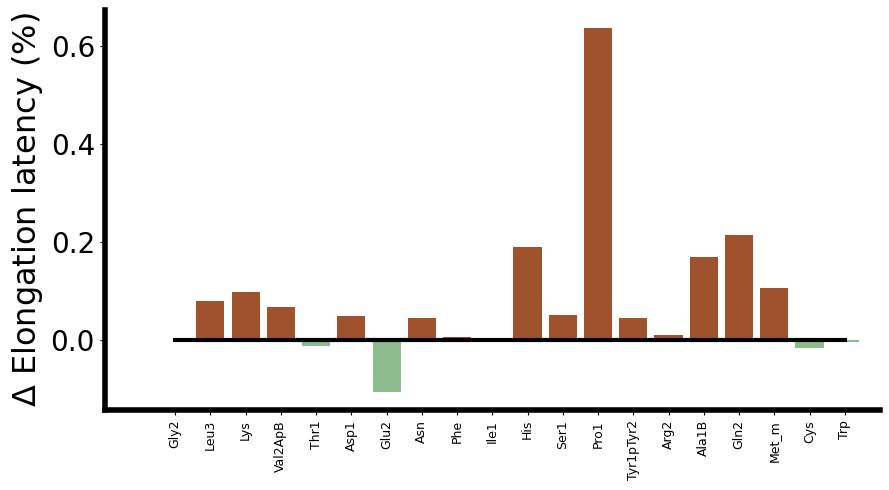

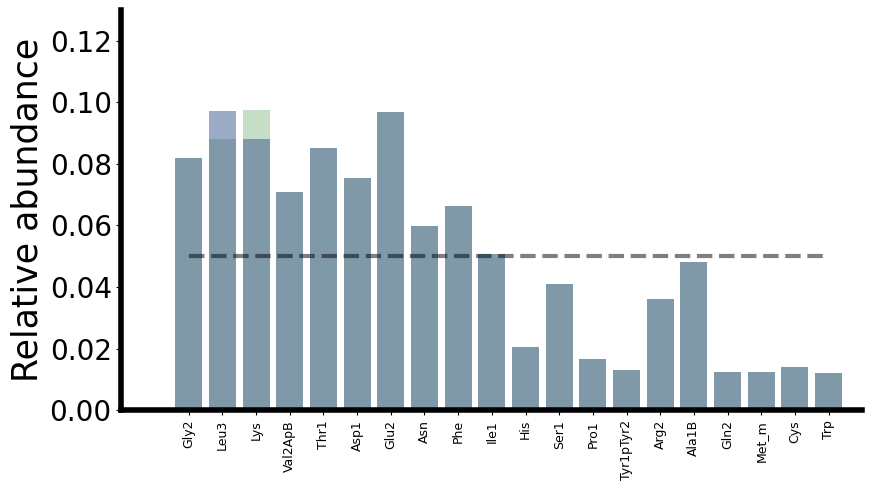

In [95]:
# Single perturbation analysis of each of the 20 tRN
baseline = perturb(GA_fast_values, tRNA_tags, np.array(tRNA_sorted)[0:20],pCodon,ensmbl_latency_dict,1,0)[0]
elongt_perturb = []
ptRNA_perturb = []
elongt_sem_perturb = []
for i in range(1,len(tRNA_sorted[0:20])):
    values = perturb(GA_fast_values, tRNA_tags, np.array(tRNA_sorted)[0:20],pCodon,ensmbl_latency_dict,i,10)
    elongt_perturb.append(values[0])
    ptRNA_perturb.append(values[1])
    elongt_sem_perturb.append(values[2])
#print(elongt_perturb - baseline)

ptRNA_dict = dict(zip(tRNA_tags,ptRNA_perturb[1]))
ptRNA_sorted_perturb =[ptRNA_dict[tRNA] for tRNA in tRNA_sorted]
print(ptRNA_sorted_perturb)

#Plotting
fig,ax = plt.subplots(figsize=(9,5))
elongt_diff = (elongt_perturb - baseline)/baseline*100
elongt_sem_norm = np.array(elongt_sem_perturb)/baseline*100
elongt_sem_norm[elongt_diff<0] = 0
elongt_sem_norm_0 = np.insert(elongt_sem_norm,0,0)
elongt_diff[elongt_diff<0] = 0
elongt_diff=np.insert(elongt_diff,0,0)

#yerr=elongt_sem_norm_0,
ax.bar(np.arange(20),elongt_diff,color='sienna',width=0.8)

elongt_diff = (elongt_perturb - baseline)/baseline*100

elongt_sem_norm = np.array(elongt_sem_perturb)/baseline*100
elongt_sem_norm[elongt_diff>0] = 0
elongt_sem_norm_1 = np.insert(elongt_sem_norm,0,0)

elongt_diff[elongt_diff>0] = 0
elongt_diff=np.insert(elongt_diff,0,0)

#yerr=elongt_sem_norm_1
ax.bar(np.arange(20),elongt_diff,color='darkseagreen',width=0.8)
ax.plot(np.arange(20),[0]*20,color='black',linewidth=3,alpha=1)
plt.xticks(np.arange(20), np.array(tRNA_sorted)[0:20],rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,20)
ax.set_ylabel('$\Delta$ Elongation latency (%)',fontsize=23)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
#ax.set_ylim(-5,5)
plt.tight_layout()

fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(20),np.array(ptRNA_min_sorted)[0:20],color='darkseagreen',width=0.8,alpha=0.5)
ax.bar(np.arange(20),np.array(ptRNA_sorted_perturb)[0:20],color='#39568CFF',width=0.8,alpha=0.5)
ax.plot(np.arange(20),[1/20]*20,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(20), np.array(tRNA_sorted)[0:20],rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,20)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_ylim(0,0.13)

plt.tight_layout()

[0.04820464 0.         0.03618178 0.         0.         0.
 0.05998136 0.07547519 0.01409508 0.         0.01254507 0.09676049
 0.08207274 0.         0.02053983 0.05074935 0.         0.
 0.08796342 0.         0.         0.09743518 0.01254507 0.0662209
 0.01664412 0.         0.         0.         0.04107876 0.
 0.         0.         0.08520427 0.         0.         0.
 0.01221374 0.0131765  0.         0.07091251]
{'Ala1B': 0.02506722398113962, 'Ala2': 0.0, 'Arg2': 0.038852112223725144, 'Arg3': 0.0, 'Arg4': 0.0, 'Arg5': 0.0, 'Asn': 0.0697010938369941, 'Asp1': 0.08844957063938365, 'Cys': 0.01471103001884435, 'Gln1': 0.0, 'Gln2': 0.018505617177668913, 'Glu2': 0.07353223082426925, 'Gly2': 0.08909894819573944, 'Gly3': 0.0, 'His': 0.04019093170902558, 'Ile1': 0.03921357269861637, 'Leu1': 0.0, 'Leu2': 0.0, 'Leu3': 0.09346713546926193, 'Leu4': 0.0, 'Leu5': 0.0, 'Lys': 0.08164850986682295, 'Met_m': 0.01619449472679119, 'Phe': 0.059770380451833714, 'Pro1': 0.02016222819738853, 'Pro2': 0.0, 'Pro3':

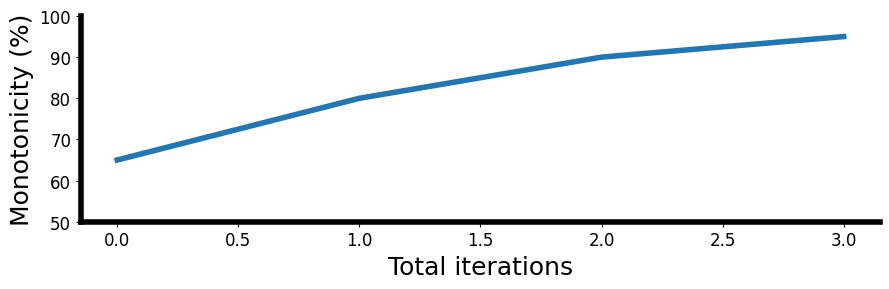

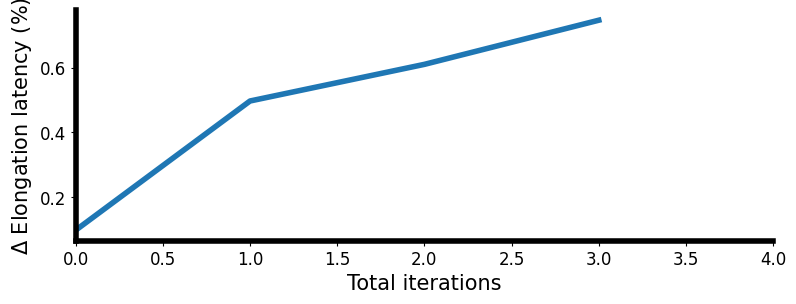

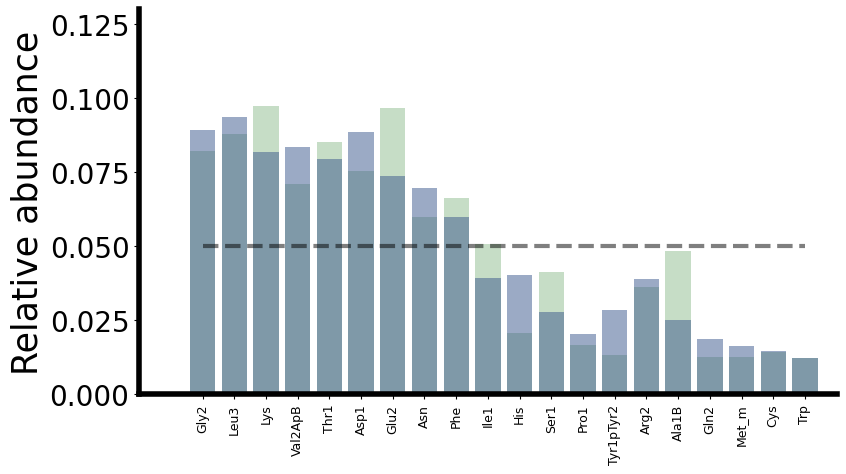

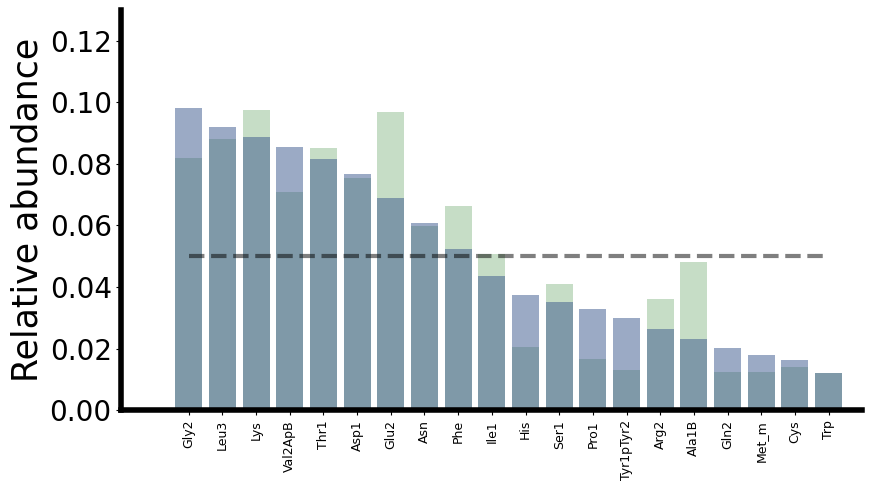

In [92]:
# Monotonicity algorithm: multiple rounds of consecutive 40-tRNA perturbation analyses,
#shifting abundance mass towards monotonicity.
# Can also have a second version of this figure that doesn't touch copies of tRNA (e.g., Leu1, Leu3)
baseline = perturb(GA_fast_values, tRNA_tags, np.array(tRNA_sorted)[0:20],pCodon,ensmbl_latency_dict,1,0)
baseline_elongt = baseline[0]
baseline_ptRNA = baseline[1]

elongt_perturb = []
ptRNA_perturb = []
elongt_sem_perturb = []


ptRNA_min_update = GA_fast_values.copy()
mono_perturb = []
count=0

ptRNA_sorted_perturb_iter = baseline_ptRNA.copy()
print(ptRNA_min_update)

while (np.diff(ptRNA_sorted_perturb_iter) > 0).any():
    count+=1
    for i in range(1,20):
        if i==19:
            values = perturb(ptRNA_min_update, tRNA_tags, np.array(tRNA_sorted)[0:20],pCodon,ensmbl_latency_dict,i,10)
        else:
            values = perturb(ptRNA_min_update, tRNA_tags, np.array(tRNA_sorted)[0:20],pCodon,ensmbl_latency_dict,i,10,skip=True)
        ptRNA_min_update = values[1]
    elongt_perturb.append(values[0])
    elongt_sem_perturb.append(values[2])
    ptRNA_dict = dict(zip(tRNA_tags,values[1]))
    print(ptRNA_dict)
    ptRNA_sorted_perturb_iter =[ptRNA_dict[tRNA] for tRNA in tRNA_sorted][0:20]
    mono_perturb.append(monotonicity(ptRNA_sorted_perturb_iter))
    ptRNA_perturb.append(ptRNA_sorted_perturb_iter)
    print("iter: ", count, " monotonicity: ", monotonicity(ptRNA_sorted_perturb_iter), "elongt: ",elongt_perturb[-1] )

print(elongt_perturb)
print(elongt_perturb - baseline_elongt)

#Monotonicity plot
fig,ax = plt.subplots(figsize=(9,3))

ax.plot(np.arange(len(mono_perturb)),mono_perturb,linewidth=4)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.set_ylabel('Monotonicity (%)',fontsize=18)
ax.set_xlabel('Total iterations',fontsize=18)

ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.set_ylim(50,100)
plt.tight_layout()

#Elongation latency % plot
fig,ax = plt.subplots(figsize=(9,3))
ax.plot(np.arange(len(elongt_perturb)),(elongt_perturb-baseline_elongt)/baseline_elongt*100,linewidth=4)
#ax.errorbar(np.arange(len(elongt_perturb)),(elongt_perturb-baseline_elongt)/baseline_elongt*100,yerr=elongt_sem_perturb/baseline_elongt*100,linewidth=4,elinewidth=2)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(0,len(elongt_perturb))


ax.set_ylabel('$\Delta$ Elongation latency (%)',fontsize=15)
ax.set_xlabel('Total iterations',fontsize=15)

ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=12)


#Plot iter 0 and final:
fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(20),np.array(ptRNA_min_sorted)[0:20],color='darkseagreen',width=0.8,alpha=0.5)
ax.bar(np.arange(20),ptRNA_perturb[0],color='#39568CFF',width=0.8,alpha=0.5)
ax.plot(np.arange(20),[1/20]*20,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(20), np.array(tRNA_sorted)[0:20],rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,20)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_ylim(0,0.13)

fig,ax = plt.subplots(figsize=(9,5))
ax.bar(np.arange(20),np.array(ptRNA_min_sorted)[0:20],color='darkseagreen',width=0.8,alpha=0.5)
ax.bar(np.arange(20),ptRNA_perturb[-1],color='#39568CFF',width=0.8,alpha=0.5)
ax.plot(np.arange(20),[1/20]*20,color='black',linewidth=3,linestyle='dashed',alpha=0.5)
plt.xticks(range(20), np.array(tRNA_sorted)[0:20],rotation='vertical')

ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(-2,20)
ax.set_ylabel('Relative abundance',fontsize=25)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=9)
ax.set_ylim(0,0.13)

plt.tight_layout()

In [ ]:
tRNA_tags = ["Ala1B", "Ala2", "Arg2", "Arg3", "Arg4", "Arg5", "Asn", "Asp1", "Cys", "Gln1", "Gln2", \
"Glu2", "Gly2", "Gly3", "His", "Ile1", "Leu1", "Leu2", "Leu3", "Leu4", "Leu5", "Lys", \
"Met_m", "Phe", "Pro1", "Pro2", "Pro3", "Sel_Cys", "Ser1", "Ser2", "Ser3", "Ser5", "Thr1", \
"Thr2", "Thr3", "Thr4", "Trp", "Tyr1pTyr2", "Val1", "Val2ApB"]
codon_tags = ['GGG', 'GGA', 'GGU', 'GGC', 'GAG', 'GAA', 'GAU', 'GAC', 'GUG', 'GUA', 'GUU', 'GUC', 'GCG', 'GCA', 'GCU', 'GCC', 'AGG', 'AGA', 'AGU', 'AGC', 'AAG', 'AAA', 'AAU', 'AAC', 'AUG', 'AUA', 'AUU', 'AUC', 'ACG', 'ACA', 'ACU', 'ACC', 'UGG', 'UGA', 'UGU', 'UGC', 'UAU', 'UAC', 'UUG', 'UUA', 'UUU', 'UUC', 'UCG', 'UCA', 'UCU', 'UCC', 'CGG', 'CGA', 'CGU', 'CGC', 'CAG', 'CAA', 'CAU', 'CAC', 'CUG', 'CUA', 'CUU', 'CUC', 'CCG', 'CCA', 'CCU', 'CCC']

gene_map, pCodon_GFP = singlegene_to_genemap('./data/tables/sfGFP_RED20.csv')
ptRNA_red20 = pd.read_excel('./data/tables/tRNAValues_RED20.xlsx',header=None)
ptRNA_red20 = ptRNA_red20[6]/sum(ptRNA_red20[6])
ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(ptRNA_red20,pCodon_GFP,extra2=True)


#Red20_codontable = pd.read_excel('./data/tables/codonValues_RED20.xlsx',header=None)
#Red20_pCodon = Red20_codontable[6]/sum(Red20_codontable[6])
#Red20_codon_dict = dict(zip(Red20_codontable[9],Red20_codontable[11]))
#Red20_pCodon_dict = dict(zip(Red20_codontable[9],Red20_pCodon))
fig,ax = plt.subplots(figsize=(12,4))

##Compute the codon distribution and elongation latency of each gene weighted by transcript number
#codon_elongt = compute_codon_elongt(gr25_ptRNA, len(gr25_pCodon), ensmbl_latency_dict)
#gene_map, gene_latency = compute_gene_elongt(codon_elongt)
#pCodon_transcriptome, transcriptome_elongt = compute_transcript_distributions(gene_map,gene_latency)

#Compute cognate distributions and sort codons by frequency
#ptRNA_dict, pcodon_dict, codon_dict, codonLabels, pCodon, tRNA_dict = cognateDistrib(gr25_ptRNA,pCodon_transcriptome,extra2=True)

codon_sorted_indices = np.flip(pCodon.argsort())
pCodon_sorted = pCodon[codon_sorted_indices]
codon_sorted = codonLabels[codon_sorted_indices]
for i,codon in enumerate(codon_sorted):
    pCodon_sorted[i] = pcodon_dict[codon]

ax.bar(np.arange(62),pCodon_sorted,color='#d8832b',width=0.8)
ax.plot(np.arange(62),[1/62]*62,color='black',linewidth=4,linestyle='dashed',alpha=0.5)
plt.xticks(range(len(codon_tags)), codon_sorted,rotation='vertical')
ax.set_xlim(-2,20)

for ax in [ax]:
    ax.spines['left'].set_linewidth(4)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(axis='y', which='major', labelsize=20)
    ax.tick_params(axis='x', which='major', labelsize=9)
    ax.set_ylabel('Relative codon usage',fontsize=22)


In [ ]:
cutoff = sorted(transcriptome_dict.values())[int(len(transcriptome_dict) * 0.1)]
transcriptome_dict = {k: v for k, v in transcriptome_dict.items() if v <= cutoff}


In [52]:
codon_elongt = compute_codon_elongt(GA_fast_values, len(gr25_pCodon), ensmbl_latency_dict)
codon_elongt2 = {k: v for k, v in codon_elongt.items() if v <= 252}
print(codon_elongt2['CAC'])
print(codon_elongt2['UCA'])
print(codon_elongt2['UCA']+codon_elongt2['CAC'])

235.34395574313086
188.70776859646588
424.0517243395967


In [53]:
codon_elongt = compute_codon_elongt(ptRNA_min_update, len(gr25_pCodon), ensmbl_latency_dict)
codon_elongt2 = {k: v for k, v in codon_elongt.items() if v <= 252}
print(codon_elongt2['CAC'])
print(codon_elongt2['UCA'])
print(codon_elongt2['UCA']+codon_elongt2['CAC'])

208.9844270566081
208.236208230737
417.2206352873451


In [51]:
codon_elongt = compute_codon_elongt(ptRNA_perturb[10], len(gr25_pCodon), ensmbl_latency_dict)
codon_elongt2 = {k: v for k, v in codon_elongt.items() if v <= 252}
print(codon_elongt2['CAC'])
print(codon_elongt2['UCA'])
print(codon_elongt2['UCA']+codon_elongt2['CAC'])

206.7658349155096
208.29828759479838
415.064122510308


In [78]:

a = 0
for i in range(1000):
    a+=computeElongationLatency(ptRNA_perturb[10], pCodon, ensmbl_latency_dict)[0][0]
a/1000
#160.042781311331 - 250
#160.05314099331014 - 500
#160.02926791123505 - 1000

#Note! Not too different from below box becausae the codon we're looking at is quite rare in gfp to begin with! So slightly off global minimum isn't as punished because need a very low temperature to find with these rare codons.

160.02926791123505

In [79]:
a = 0
for i in range(1000):
    a+=computeElongationLatency(GA_fast_values, pCodon, ensmbl_latency_dict)[0][0]
a/1000
#159.99378016072745
#160.07129959098955
#159.93425911109247

159.93425911109247

In [81]:
a = 0
for i in range(1000):
    a+=computeElongationLatency(ptRNA_perturb[0], pCodon, ensmbl_latency_dict)[0][0]
a/1000
#159.93638580485106
#160.0157273751606
#159.9124711023047

159.9124711023047

In [17]:
a = 0
for i in range(10):
    a+=computeElongationLatency(GA_fast_values, pCodon, ensmbl_latency_dict)[0][0]
a/10

160.01165143504574

In [18]:
a = 0
for i in range(10):
    a+=computeElongationLatency(ptRNA_min_update, pCodon, ensmbl_latency_dict)[0][0]
a/10


161.33002375899713

In [36]:
a = []
for i in range(1,13):
    a.append(ensmbl_latency_dict[i].avg_searchT)

In [80]:
def perturb_one(ptRNA,tRNA,tRNA_sorted, pCodon,ensmbl_latency_dict,pos,delta,skip=False,flip=False):
    #Delta is not taken into the account in this function (hard coded as 0.1)
    
    ptRNA_red20 = np.array([0.07175573, 0.        , 0.09770992, 0.        , 0.        ,
       0.        , 0.02137405, 0.04427481, 0.02137405, 0.        ,
       0.03053435, 0.08549618, 0.10534351, 0.        , 0.01221374,
       0.07175573, 0.        , 0.        , 0.12824427, 0.        ,
       0.        , 0.03053435, 0.01374046, 0.01526718, 0.0259542 ,
       0.        , 0.        , 0.        , 0.05496183, 0.        ,
       0.        , 0.        , 0.04732824, 0.        , 0.        ,
       0.        , 0.01526718, 0.02748092, 0.        , 0.07938931])
    ptRNA_maxval = max(np.array(ptRNA_red20)[np.nonzero(np.array(ptRNA_red20))])
    ptRNA_minval = min(np.array(ptRNA_red20)[np.nonzero(np.array(ptRNA_red20))])
    ptRNA_dict = dict(zip(tRNA, ptRNA))
    tRNA_1 = tRNA_sorted[pos]
    tRNA_0 = tRNA_sorted[pos-1]
    if flip:
        tRNA_0 = tRNA_sorted[pos]
        tRNA_1 = tRNA_sorted[pos-1]
    
    elongation_arr = []
    tRNA0_vals = []
    tRNA1_vals = []
    
    N=100
    while ptRNA_dict[tRNA_0]<ptRNA_maxval and ptRNA_dict[tRNA_1]>ptRNA_minval:
        tRNA0_vals.append(ptRNA_dict[tRNA_0])
        tRNA1_vals.append(ptRNA_dict[tRNA_1])
        arr = []
        for i in range(N):
            arr.append(computeElongationLatency(np.array(list(ptRNA_dict.values())), pCodon, ensmbl_latency_dict)[0][0])
        elongation_arr.append(np.average(arr))
        print(ptRNA_dict[tRNA_0],ptRNA_dict[tRNA_1])
        ptRNA_dict[tRNA_0] += 0.005
        ptRNA_dict[tRNA_1] -= 0.005
        
    return elongation_arr, tRNA0_vals, tRNA1_vals
    

In [81]:
# Single perturbation analysis of each of the 20 tRN
single_perturb = perturb_one(GA_fast_values, tRNA_tags, np.array(tRNA_sorted)[0:20],pCodon,ensmbl_latency_dict,1,1)
single_perturb

0.08207273693853659 0.08796342374035546
0.0870727369385366 0.08296342374035545
0.0920727369385366 0.07796342374035545
0.0970727369385366 0.07296342374035544
0.1020727369385366 0.06796342374035544
0.10707273693853661 0.06296342374035543
0.11207273693853662 0.05796342374035544
0.11707273693853662 0.05296342374035544
0.12207273693853662 0.04796342374035544
0.12707273693853663 0.042963423740355444


([159.96720568942442,
  160.1112084479503,
  160.0146125847393,
  160.17143752061367,
  160.37953164192882,
  160.4705552977614,
  160.7713233311518,
  161.03165671272922,
  161.59562299129425,
  162.07969337318045],
 [0.08207273693853659,
  0.0870727369385366,
  0.0920727369385366,
  0.0970727369385366,
  0.1020727369385366,
  0.10707273693853661,
  0.11207273693853662,
  0.11707273693853662,
  0.12207273693853662,
  0.12707273693853663],
 [0.08796342374035546,
  0.08296342374035545,
  0.07796342374035545,
  0.07296342374035544,
  0.06796342374035544,
  0.06296342374035543,
  0.05796342374035544,
  0.05296342374035544,
  0.04796342374035544,
  0.042963423740355444])

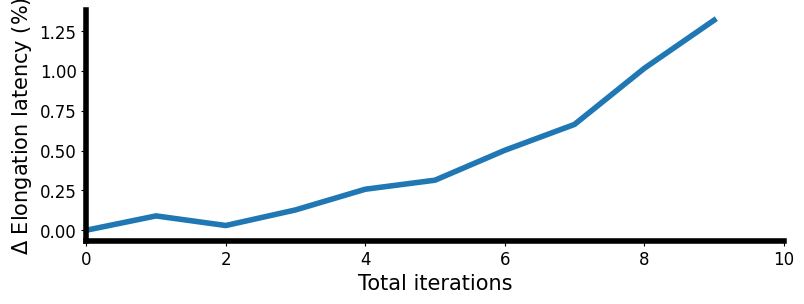

In [82]:
#plt.plot(range(len(single_perturb[0])),single_perturb[0])

fig,ax = plt.subplots(figsize=(9,3))
ax.plot(np.arange(len(np.array(single_perturb[0]))),(np.array(single_perturb[0])-np.array(single_perturb[0])[0])/np.array(single_perturb[0])[0]*100,linewidth=4)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(0,len(np.array(single_perturb[0])))


ax.set_ylabel('$\Delta$ Elongation latency (%)',fontsize=15)
ax.set_xlabel('Total iterations',fontsize=15)

ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=12)

In [83]:
# Single perturbation analysis of each of the 20 tRNA
single_perturb = perturb_one(GA_fast_values, tRNA_tags, np.array(tRNA_sorted)[0:20],pCodon,ensmbl_latency_dict,1,1,flip=True)
single_perturb

0.08796342374035546 0.08207273693853659
0.09296342374035546 0.07707273693853658
0.09796342374035547 0.07207273693853658
0.10296342374035547 0.06707273693853658
0.10796342374035547 0.06207273693853658
0.11296342374035548 0.05707273693853658
0.11796342374035548 0.05207273693853658
0.12296342374035549 0.047072736938536586
0.1279634237403555 0.04207273693853659


([160.01316647119674,
  160.2061468335266,
  160.4071021302561,
  160.79854143363147,
  160.86527337863575,
  161.3020912897854,
  161.85052461879712,
  162.23450561382313,
  162.94510946084944],
 [0.08796342374035546,
  0.09296342374035546,
  0.09796342374035547,
  0.10296342374035547,
  0.10796342374035547,
  0.11296342374035548,
  0.11796342374035548,
  0.12296342374035549,
  0.1279634237403555],
 [0.08207273693853659,
  0.07707273693853658,
  0.07207273693853658,
  0.06707273693853658,
  0.06207273693853658,
  0.05707273693853658,
  0.05207273693853658,
  0.047072736938536586,
  0.04207273693853659])

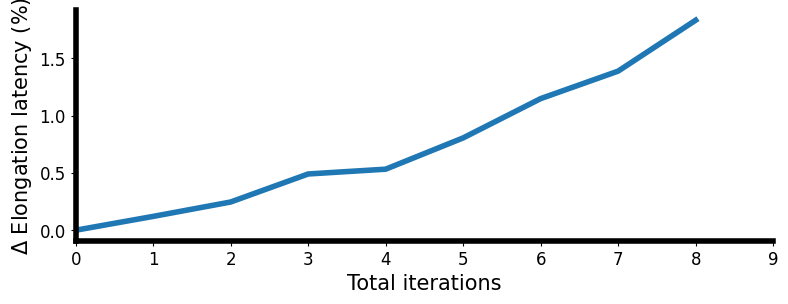

In [84]:
fig,ax = plt.subplots(figsize=(9,3))
ax.plot(np.arange(len(np.array(single_perturb[0]))),(np.array(single_perturb[0])-np.array(single_perturb[0])[0])/np.array(single_perturb[0])[0]*100,linewidth=4)
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
ax.spines['top'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)
ax.set_xlim(0,len(np.array(single_perturb[0])))


ax.set_ylabel('$\Delta$ Elongation latency (%)',fontsize=15)
ax.set_xlabel('Total iterations',fontsize=15)

ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=12)